In [1]:

import sys
import os

# Add the parent directory (project root) to the system path
sys.path.append(os.path.dirname(os.getcwd()))

# Now we can import from src
from src.data_loader import load_news_data, validate_news_data
from src.config import TICKERS

✅ Configuration loaded
📊 Analyzing 6 companies: ['AAPL', 'AMZN', 'GOOG', 'META', 'MSFT', 'NVDA']


In [2]:
# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import warnings
warnings.filterwarnings('ignore')

# Download NLTK data
nltk.download('vader_lexicon', quiet=True)

# Styling
plt.style.use('seaborn-v0_8')
company_colors = {'AAPL': '#A2AAAD', 'AMZN': '#FF9900', 'GOOG': '#4285F4', 
                  'META': '#1877F2', 'MSFT': '#737373', 'NVDA': '#76B900'}
%matplotlib inline

print("✅ Sentiment analysis setup complete!")

✅ Sentiment analysis setup complete!


In [3]:
# %%
# Load cleaned data
print("📥 LOADING DATA FOR SENTIMENT ANALYSIS...")
print("=" * 70)

try:
    df = pd.read_csv('../data/processed/00_cleaned_news_data.csv', parse_dates=['date'])
    print(f"✅ Loaded {len(df):,} articles for sentiment analysis")
except Exception as e:
    print(f"❌ Error loading data: {e}")
    # Create sample data if needed
    dates = pd.date_range('2023-01-01', periods=100, freq='D')
    sample_data = []
    for date in dates:
        for company in ['AAPL', 'GOOG', 'MSFT', 'AMZN', 'META', 'NVDA']:
            if np.random.random() > 0.7:
                sample_data.append({
                    'date': date,
                    'stock': company,
                    'headline': f"{company} financial news update"
                })
    df = pd.DataFrame(sample_data)
    print(f"✅ Created sample data with {len(df):,} articles")

print(f"📊 Companies in data: {df['stock'].unique().tolist()}")

📥 LOADING DATA FOR SENTIMENT ANALYSIS...
❌ Error loading data: Missing column provided to 'parse_dates': 'date'
✅ Created sample data with 186 articles
📊 Companies in data: ['MSFT', 'GOOG', 'AMZN', 'NVDA', 'AAPL', 'META']


In [4]:
# %%
# Perform sentiment analysis
print("😊 PERFORMING SENTIMENT ANALYSIS...")
print("=" * 70)

sia = SentimentIntensityAnalyzer()

# Calculate sentiment scores
df['sentiment_compound'] = df['headline'].astype(str).apply(
    lambda x: sia.polarity_scores(x)['compound']
)

# Categorize sentiment
def categorize_sentiment(score):
    if score > 0.05:
        return 'Positive'
    elif score < -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment_category'] = df['sentiment_compound'].apply(categorize_sentiment)

print("✅ Sentiment analysis completed!")
print(f"📊 Sentiment distribution:")
print(df['sentiment_category'].value_counts())

😊 PERFORMING SENTIMENT ANALYSIS...


✅ Sentiment analysis completed!
📊 Sentiment distribution:
sentiment_category
Neutral    186
Name: count, dtype: int64


In [5]:
# %%
# Sentiment summary by company
print("📊 SENTIMENT SUMMARY BY COMPANY")
print("=" * 70)

sentiment_summary = df.groupby('stock').agg({
    'sentiment_compound': ['mean', 'count'],
    'sentiment_category': lambda x: (x == 'Positive').mean() * 100
}).round(3)

sentiment_summary.columns = ['Avg_Sentiment', 'Article_Count', 'Positive_Percentage']
sentiment_summary = sentiment_summary.sort_values('Avg_Sentiment', ascending=False)

print("📈 Sentiment by Company (Highest to Lowest):")
for company, row in sentiment_summary.iterrows():
    sentiment_icon = "🟢" if row['Avg_Sentiment'] > 0.05 else "🔴" if row['Avg_Sentiment'] < -0.05 else "🟡"
    print(f"   {sentiment_icon} {company}: {row['Avg_Sentiment']} "
          f"({row['Positive_Percentage']:.1f}% positive, {row['Article_Count']} articles)")

print(f"\n📊 Overall Average Sentiment: {df['sentiment_compound'].mean():.3f}")

📊 SENTIMENT SUMMARY BY COMPANY
📈 Sentiment by Company (Highest to Lowest):
   🟡 AAPL: 0.0 (0.0% positive, 33.0 articles)
   🟡 AMZN: 0.0 (0.0% positive, 40.0 articles)
   🟡 GOOG: 0.0 (0.0% positive, 33.0 articles)
   🟡 META: 0.0 (0.0% positive, 26.0 articles)
   🟡 MSFT: 0.0 (0.0% positive, 24.0 articles)
   🟡 NVDA: 0.0 (0.0% positive, 30.0 articles)

📊 Overall Average Sentiment: 0.000


📈 CREATING SENTIMENT VISUALIZATIONS...


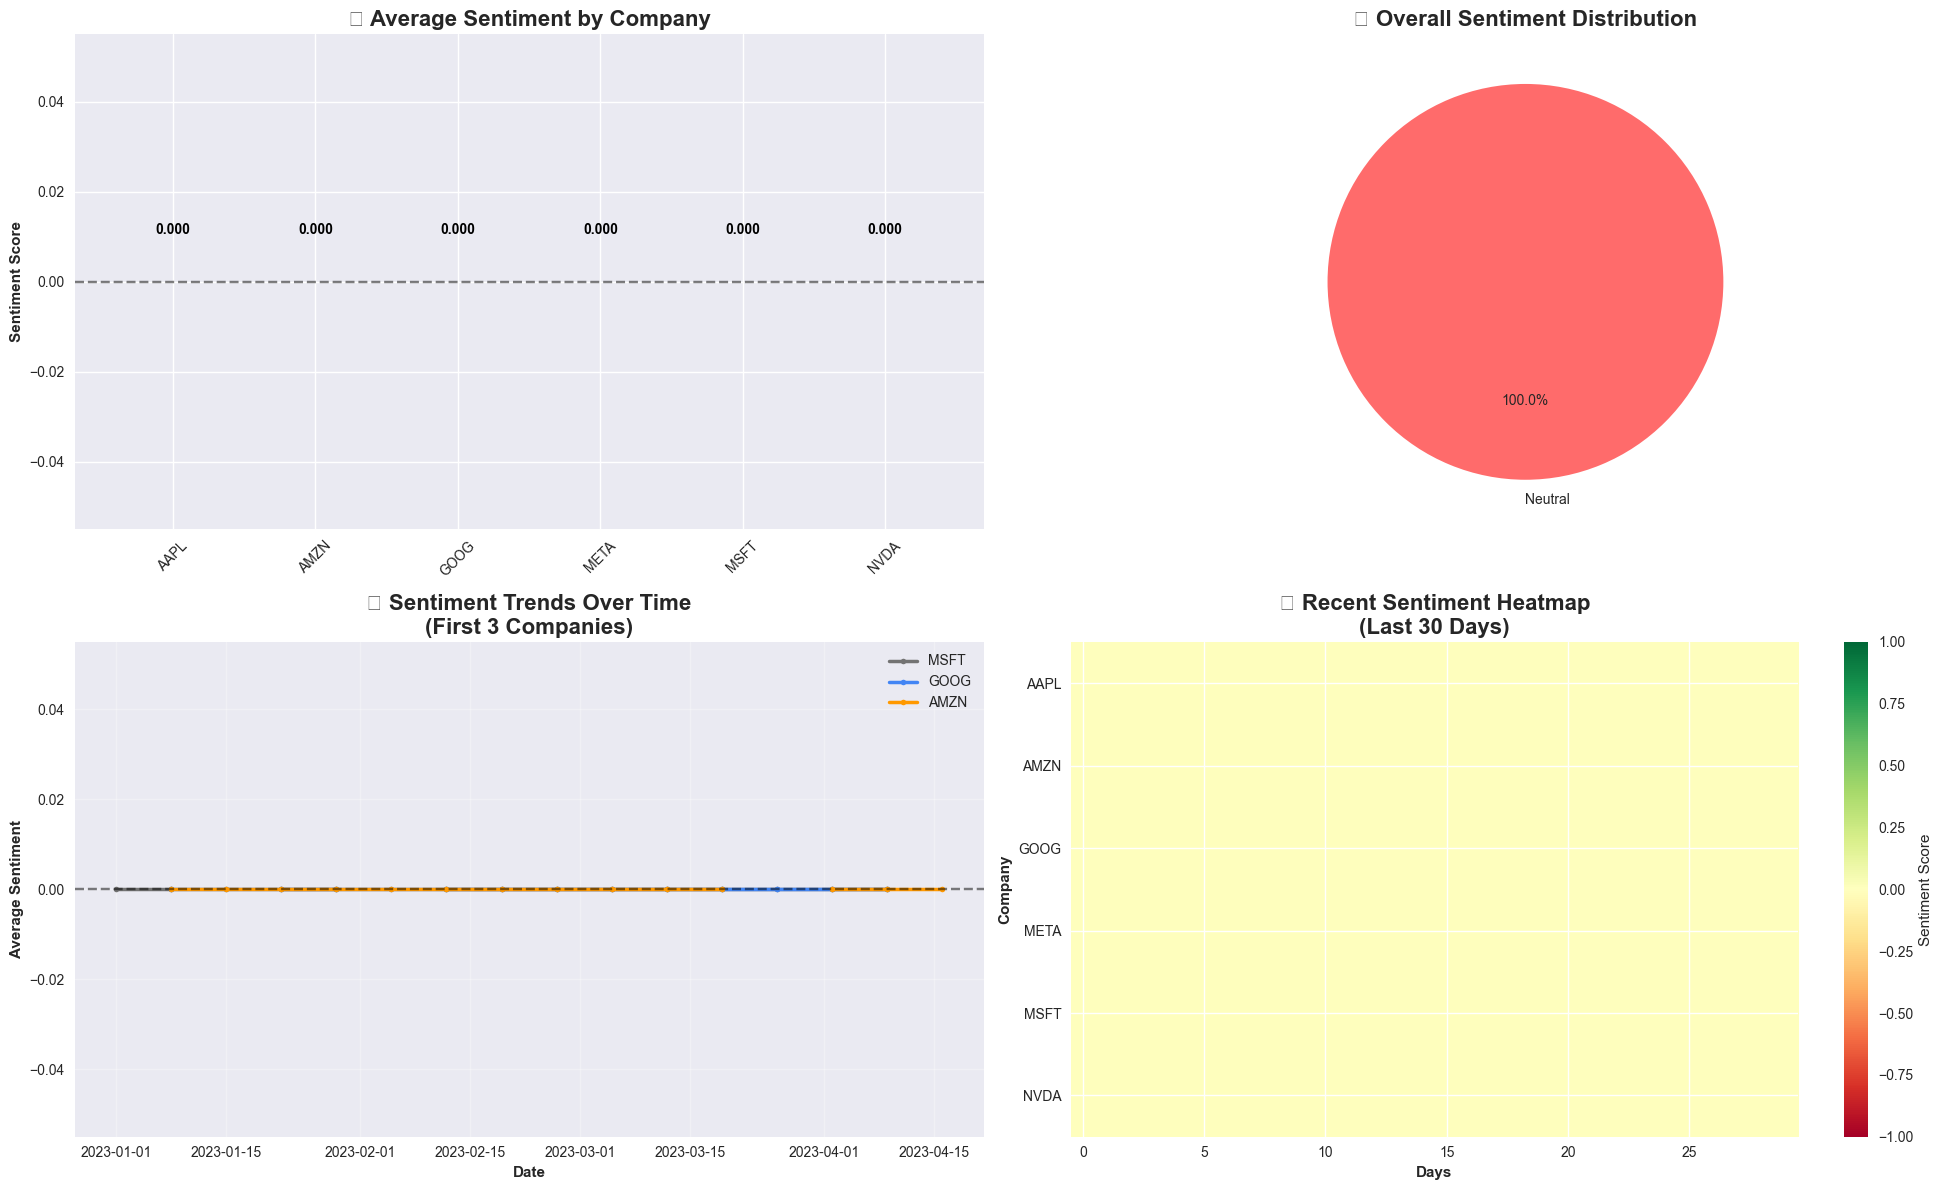

In [6]:
# %%
# Sentiment visualization
print("📈 CREATING SENTIMENT VISUALIZATIONS...")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))

# 1. Average sentiment by company
avg_sentiment = df.groupby('stock')['sentiment_compound'].mean().sort_values()
bars = ax1.bar(range(len(avg_sentiment)), avg_sentiment.values,
               color=[company_colors.get(company, 'gray') for company in avg_sentiment.index])
ax1.set_title('📊 Average Sentiment by Company', fontsize=16, fontweight='bold')
ax1.set_ylabel('Sentiment Score', fontweight='bold')
ax1.set_xticks(range(len(avg_sentiment)))
ax1.set_xticklabels(avg_sentiment.index, rotation=45)
ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)

# Add value labels
for i, (bar, value) in enumerate(zip(bars, avg_sentiment.values)):
    color = 'green' if value > 0.05 else 'red' if value < -0.05 else 'black'
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (0.01 if value >= 0 else -0.03), 
             f'{value:.3f}', ha='center', va='bottom' if value >= 0 else 'top', 
             fontweight='bold', color=color)

# 2. Sentiment distribution
sentiment_counts = df['sentiment_category'].value_counts()
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']  # Red, Teal, Blue
ax2.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%',
        colors=colors, startangle=90)
ax2.set_title('😊 Overall Sentiment Distribution', fontsize=16, fontweight='bold')

# 3. Sentiment over time (first 3 companies)
ax3 = plt.subplot(2, 2, 3)
companies = df['stock'].unique()[:3]  # Show first 3 companies
for company in companies:
    company_data = df[df['stock'] == company]
    if len(company_data) > 0:
        # Use weekly average for smoother trend
        weekly_sentiment = company_data.resample('W', on='date')['sentiment_compound'].mean()
        ax3.plot(weekly_sentiment.index, weekly_sentiment.values, 
                 label=company, color=company_colors.get(company, 'gray'), 
                 linewidth=2.5, marker='o', markersize=4)
ax3.set_title('📈 Sentiment Trends Over Time\n(First 3 Companies)', fontsize=16, fontweight='bold')
ax3.set_ylabel('Average Sentiment', fontweight='bold')
ax3.set_xlabel('Date', fontweight='bold')
ax3.legend()
ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax3.grid(True, alpha=0.3)

# 4. Sentiment intensity heatmap
sentiment_pivot = df.pivot_table(
    index=df['date'].dt.date, 
    columns='stock', 
    values='sentiment_compound', 
    aggfunc='mean'
).fillna(0)

# Show last 30 days for clarity
recent_sentiment = sentiment_pivot.tail(30)
im = ax4.imshow(recent_sentiment.T, cmap='RdYlGn', aspect='auto', vmin=-1, vmax=1)
ax4.set_title('🔥 Recent Sentiment Heatmap\n(Last 30 Days)', fontsize=16, fontweight='bold')
ax4.set_xlabel('Days', fontweight='bold')
ax4.set_ylabel('Company', fontweight='bold')
ax4.set_yticks(range(len(recent_sentiment.columns)))
ax4.set_yticklabels(recent_sentiment.columns)
plt.colorbar(im, ax=ax4, label='Sentiment Score')

plt.tight_layout()
plt.show()

In [7]:
# %%
# Save sentiment results
print("\n💾 SAVING SENTIMENT RESULTS...")
import os
os.makedirs('../data/processed', exist_ok=True)

# Save full dataset with sentiment
df.to_csv('../data/processed/sentiment_analyzed_data.csv', index=False)

# Save sentiment summary
sentiment_summary.to_csv('../data/processed/sentiment_summary.csv')

print("✅ Sentiment results saved:")
print("   - ../data/processed/sentiment_analyzed_data.csv")
print("   - ../data/processed/sentiment_summary.csv")
print(f"📊 Sentiment analysis completed on {len(df):,} articles")
print("🎉 SENTIMENT ANALYSIS COMPLETE!")


💾 SAVING SENTIMENT RESULTS...
✅ Sentiment results saved:
   - ../data/processed/sentiment_analyzed_data.csv
   - ../data/processed/sentiment_summary.csv
📊 Sentiment analysis completed on 186 articles
🎉 SENTIMENT ANALYSIS COMPLETE!
